In [29]:
#Librairies
import pandas as pd
import numpy as np
import math
from datetime import timezone, datetime, timedelta

import matplotlib.pyplot as plt

from pyproj import Geod

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cluster import KMeans

from shapely.geometry import MultiLineString, Polygon, LineString
from shapely.ops import polygonize
import geopandas as gpd
from shapely.geometry import Point
from geopandas.tools import sjoin
from adjustText import adjust_text 

import itertools
import collections
from collections import Counter

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

import contextily as ctx
from rasterio.crs import CRS

%matplotlib inline

In [30]:
df_dev = pd.read_csv('donnees_GNSS_Europa.csv', sep=',', header=0)

In [31]:
df_dev.head()

devadd  gatewayid   timestamp  snr  rssi        lat        lng    ehpe  \
0  1ff0fe9c          0  1610930653   13   -70 -22.343824  40.340537  79.282   
1  1ff0fe9c          0  1610930772   13   -65 -22.343997  40.340147  27.729   
2  1ff0fe9c          0  1610930891   12   -67 -22.344038  40.340096   4.570   
3  1ff0fe9c          0  1610931010    8   -67 -22.344044  40.340106   3.690   
4  1ff0fe9c          0  1610931129    9   -67 -22.344044  40.340106   3.669   

    hdop  ttf  nbSat  noFixCount  zeroSatTimeout  
0  10300    0     16           0               0  
1   1230    0     16           0               0  
2    990    0     20           0               0  
3    960    0     19           0               0  
4    960    0     19           0               0

In [32]:
df_gtw = pd.read_csv('Suivi_info_gateway_tortue.csv', sep=',', header=0)

In [33]:
df_gtw.head()

Pseudo    model               eui sub-network role in network  short ID  \
0      Main  RAK7249  ac1f09fffe00a96d      Europa         Main GW         0   
1      dune  RAK7249  ac1f09fffe00a84f      Europa    Secondary GW         5   
2     lagon  RAK7249  ac1f09fffe00a8d6      Europa    Secondary GW         3   
3  mangrove  RAK7249  ac1f09fffe00a8d2      Europa    Secondary GW         4   

  Program loaded  ping freq               System time           Id / pwd  \
0       Main-gtw         no  UTC (updated 01/06/2021)  root / ifremer974   
1  Secondary-gtw  868.3 MHz  UTC (updated 01/06/2021)        root / root   
2  Secondary-gtw  867.7 MHz  UTC (updated 01/06/2021)        root / root   
3  Secondary-gtw  867.3 MHz  UTC (updated 01/06/2021)        root / root   

  Tunnel VPN Openvpn name Target application network  Longitude   Latitude  
0  Disabled             -                 Chirpstack  40.340192 -22.343807  
1   Disabled            -                 Chirpstack  40.372063 -22.342677  
2   Disabled            -                 Chirpstack  40.375278 -22.358056  
3   Disabled            -                 Chirpstack  40.391667 -22.364167

In [34]:
df = pd.DataFrame()
df = df_dev.drop(['devadd','hdop','ttf','nbSat','noFixCount','zeroSatTimeout'],axis=1)
df = pd.merge(df,df_gtw[['short ID', 'Pseudo','Longitude', 'Latitude']],left_on='gatewayid',right_on='short ID', how='left').drop('short ID', axis=1)
df['timestamp'] = df['timestamp'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.rename(columns={"lat": "objlat", "lng": "objlng", "Longitude":"gatewaylng", "Latitude":"gatewaylat", "Pseudo":"gatewayname"})
#df['rssi'] = df['rssi']-256
#df['rssi'] = df.apply(lambda row: row['rssi']-256 if row['rssi']> 0 else row['rssi'], axis=1)
#df.set_index(['timestamp','gatewayid'], inplace=True)
#df['rssi'] = df['rssi'].mask(df['rssi']>0)
#df.dropna()
df.drop(df.index[df['rssi']>0], inplace = True)
df.head()

gatewayid           timestamp  snr  rssi     objlat     objlng    ehpe  \
0          0 2021-01-18 00:44:13   13   -70 -22.343824  40.340537  79.282   
1          0 2021-01-18 00:46:12   13   -65 -22.343997  40.340147  27.729   
2          0 2021-01-18 00:48:11   12   -67 -22.344038  40.340096   4.570   
3          0 2021-01-18 00:50:10    8   -67 -22.344044  40.340106   3.690   
4          0 2021-01-18 00:52:09    9   -67 -22.344044  40.340106   3.669   

  gatewayname  gatewaylng  gatewaylat  
0        Main   40.340192  -22.343807  
1        Main   40.340192  -22.343807  
2        Main   40.340192  -22.343807  
3        Main   40.340192  -22.343807  
4        Main   40.340192  -22.343807

In [35]:
wgs84_geod = Geod(ellps='WGS84')

def Distance(lat1,lon1,lat2,lon2):
  az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2)
  return dist

#Distance en mètre
df['distancegps'] = Distance(df['gatewaylat'].tolist(),df['gatewaylng'].tolist(),df['objlat'].tolist(),df['objlng'].tolist())
df.head()

gatewayid           timestamp  snr  rssi     objlat     objlng    ehpe  \
0          0 2021-01-18 00:44:13   13   -70 -22.343824  40.340537  79.282   
1          0 2021-01-18 00:46:12   13   -65 -22.343997  40.340147  27.729   
2          0 2021-01-18 00:48:11   12   -67 -22.344038  40.340096   4.570   
3          0 2021-01-18 00:50:10    8   -67 -22.344044  40.340106   3.690   
4          0 2021-01-18 00:52:09    9   -67 -22.344044  40.340106   3.669   

  gatewayname  gatewaylng  gatewaylat  distancegps  
0        Main   40.340192  -22.343807    35.606578  
1        Main   40.340192  -22.343807    21.547111  
2        Main   40.340192  -22.343807    27.420959  
3        Main   40.340192  -22.343807    27.726208  
4        Main   40.340192  -22.343807    27.684867

In [36]:
grouped_gtw=df.groupby("gatewayname")

### RSSI distribution

#### Cells

In [37]:
#Discretize
#df['group_rssi'] = df.groupby('gatewayname')[['rssi']].transform(lambda x: pd.cut(x, bins = 50).astype(str))
df['group_rssi'] = df['rssi'].transform(lambda x: pd.cut(x, bins = 20).astype(str))
df.head()

gatewayid           timestamp  snr  rssi     objlat     objlng    ehpe  \
0          0 2021-01-18 00:44:13   13   -70 -22.343824  40.340537  79.282   
1          0 2021-01-18 00:46:12   13   -65 -22.343997  40.340147  27.729   
2          0 2021-01-18 00:48:11   12   -67 -22.344038  40.340096   4.570   
3          0 2021-01-18 00:50:10    8   -67 -22.344044  40.340106   3.690   
4          0 2021-01-18 00:52:09    9   -67 -22.344044  40.340106   3.669   

  gatewayname  gatewaylng  gatewaylat  distancegps       group_rssi  
0        Main   40.340192  -22.343807    35.606578  (-72.7, -68.75]  
1        Main   40.340192  -22.343807    21.547111  (-68.75, -64.8]  
2        Main   40.340192  -22.343807    27.420959  (-68.75, -64.8]  
3        Main   40.340192  -22.343807    27.726208  (-68.75, -64.8]  
4        Main   40.340192  -22.343807    27.684867  (-68.75, -64.8]

In [38]:
step = 9
M = np.linspace(df['objlng'].min(), df['objlng'].max(), step)
N = np.linspace(df['objlat'].min(), df['objlat'].max(), step)

hlines = [((x1, yi), (x2, yi)) for x1, x2 in zip(M[:-1], M[1:]) for yi in N]
vlines = [((xi, y1), (xi, y2)) for y1, y2 in zip(N[:-1], N[1:]) for xi in M]

polys = list(polygonize(MultiLineString(hlines + vlines)))
idx = [i for i in range(len(polys))]
grid = gpd.GeoDataFrame({"id":idx,"geometry":polys})

In [39]:
df_geo = df.filter(['rssi','objlng','objlat','gatewayname', 'group_rssi'],axis=1)
gdf = gpd.GeoDataFrame(
    df_geo, geometry=gpd.points_from_xy(df_geo['objlng'], df_geo['objlat']))

grouped = gdf.groupby('gatewayname')

In [40]:
#grid=grid.set_crs('epsg:4326')
#gdf=gdf.set_crs('epsg:4326')

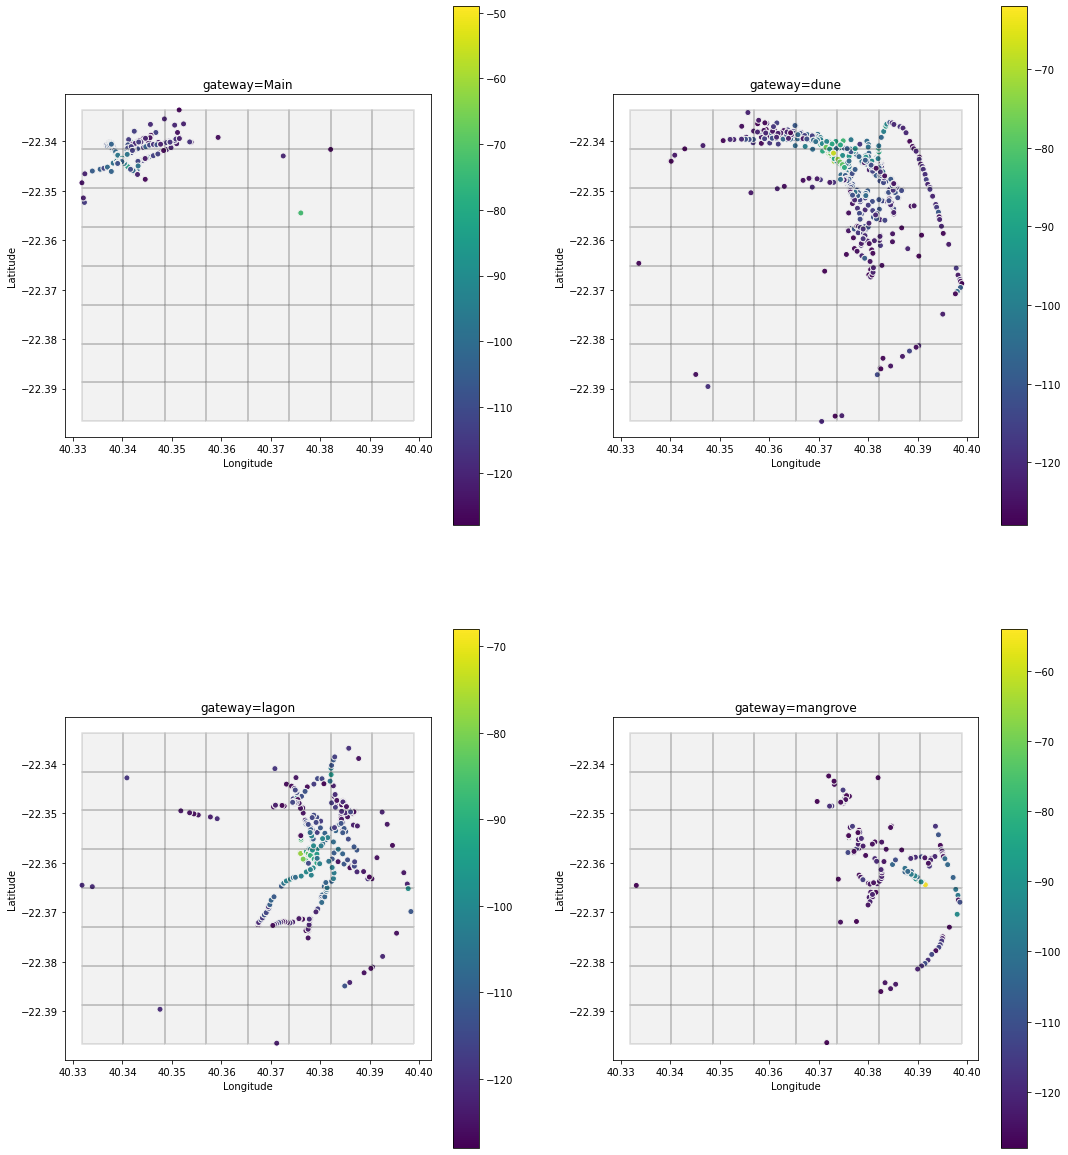

In [41]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,21),sharey=False)

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    grouped.get_group(key).plot("rssi", cmap='viridis', ax=ax, edgecolors= "white",legend=True) 
    grid.plot(ax=ax,facecolor='gray',alpha=.1,edgecolor='black',lw=2)
    ax.set(xlabel="Longitude", ylabel="Latitude")
    ax.set_title('gateway=%s'%key)
    

In [42]:
pointInPolys = sjoin(gdf, grid, how='left')
#Number of points in cell (global)
#print(pointInPolys.groupby(['id']).size().reset_index(name='count'))

In [43]:
pointInPolys.head()

rssi     objlng     objlat gatewayname       group_rssi  \
0   -70  40.340537 -22.343824        Main  (-72.7, -68.75]   
1   -65  40.340147 -22.343997        Main  (-68.75, -64.8]   
2   -67  40.340096 -22.344038        Main  (-68.75, -64.8]   
3   -67  40.340106 -22.344044        Main  (-68.75, -64.8]   
4   -67  40.340106 -22.344044        Main  (-68.75, -64.8]   

                     geometry  index_right  id  
0  POINT (40.34054 -22.34382)           14  14  
1  POINT (40.34015 -22.34400)            6   6  
2  POINT (40.34010 -22.34404)            6   6  
3  POINT (40.34011 -22.34404)            6   6  
4  POINT (40.34011 -22.34404)            6   6

In [44]:
df_proba_msg = (
    pointInPolys.groupby(['gatewayname','group_rssi', 'id']).count() / pointInPolys.groupby(['gatewayname','group_rssi']).count()
)['rssi']\
.pipe(pd.DataFrame)\
.rename(columns = {'rssi': 'proba'})\
.reset_index()

df_proba_msg.head()

gatewayname        group_rssi  id     proba
0        Main  (-100.35, -96.4]   6  0.791411
1        Main  (-100.35, -96.4]   7  0.006135
2        Main  (-100.35, -96.4]  14  0.171779
3        Main  (-100.35, -96.4]  15  0.003067
4        Main  (-100.35, -96.4]  45  0.027607

In [45]:
df_proba_msg.tail()

gatewayname       group_rssi  id     proba
383    mangrove  (-84.55, -80.6]  60  1.000000
384    mangrove  (-92.45, -88.5]  52  0.666667
385    mangrove  (-92.45, -88.5]  59  0.333333
386    mangrove  (-96.4, -92.45]  52  0.500000
387    mangrove  (-96.4, -92.45]  60  0.500000

In [46]:
#df_proba_msg[['id','group_rssi']].apply(pd.Series.value_counts)
occ = pd.DataFrame(df_proba_msg.groupby('group_rssi')['id'].value_counts().loc[lambda x : x>1])
occ = occ.rename(columns = {'id': 'count'}).reset_index()
occ.head()

group_rssi  id  count
0   (-100.35, -96.4]  45      3
1   (-100.35, -96.4]  14      2
2   (-100.35, -96.4]  46      2
3   (-100.35, -96.4]  59      2
4  (-104.3, -100.35]  45      4

In [47]:
arr_group_rssi = occ['group_rssi'].tolist()
arr_id_cell = occ['id'].tolist()

In [48]:
df_proba_msg.head()

gatewayname        group_rssi  id     proba
0        Main  (-100.35, -96.4]   6  0.791411
1        Main  (-100.35, -96.4]   7  0.006135
2        Main  (-100.35, -96.4]  14  0.171779
3        Main  (-100.35, -96.4]  15  0.003067
4        Main  (-100.35, -96.4]  45  0.027607

In [49]:
t = pd.merge(grid, df_proba_msg, on='id',  how='right')
t['coords'] = t['geometry'].apply(lambda x: x.representative_point().coords[:])
t['coords'] = [coords[0] for coords in t['coords']]
grouped = t.groupby(['gatewayname','group_rssi'], as_index=True)

In [50]:
t['tuples_plot'] = list(zip(t['gatewayname'], t['group_rssi']))

In [51]:
t.head()

id                                           geometry gatewayname  \
0   6  POLYGON ((40.34020 -22.34944, 40.33181 -22.349...        Main   
1   7  POLYGON ((40.34020 -22.34158, 40.33181 -22.341...        Main   
2  14  POLYGON ((40.34858 -22.34944, 40.34020 -22.349...        Main   
3  15  POLYGON ((40.34858 -22.34158, 40.34020 -22.341...        Main   
4  45  POLYGON ((40.38213 -22.35731, 40.37374 -22.357...        Main   

         group_rssi     proba                                coords  \
0  (-100.35, -96.4]  0.791411       (40.3360025125, -22.3455103625)   
1  (-100.35, -96.4]  0.006135  (40.3360025125, -22.337643987499998)   
2  (-100.35, -96.4]  0.171779       (40.3443889375, -22.3455103625)   
3  (-100.35, -96.4]  0.003067  (40.3443889375, -22.337643987499998)   
4  (-100.35, -96.4]  0.027607  (40.377934637500005, -22.3533767375)   

                tuples_plot  
0  (Main, (-100.35, -96.4])  
1  (Main, (-100.35, -96.4])  
2  (Main, (-100.35, -96.4])  
3  (Main, (-100.35, -96.4])  
4  (Main, (-100.35, -96.4])

In [52]:
len(grouped.groups.keys())

71

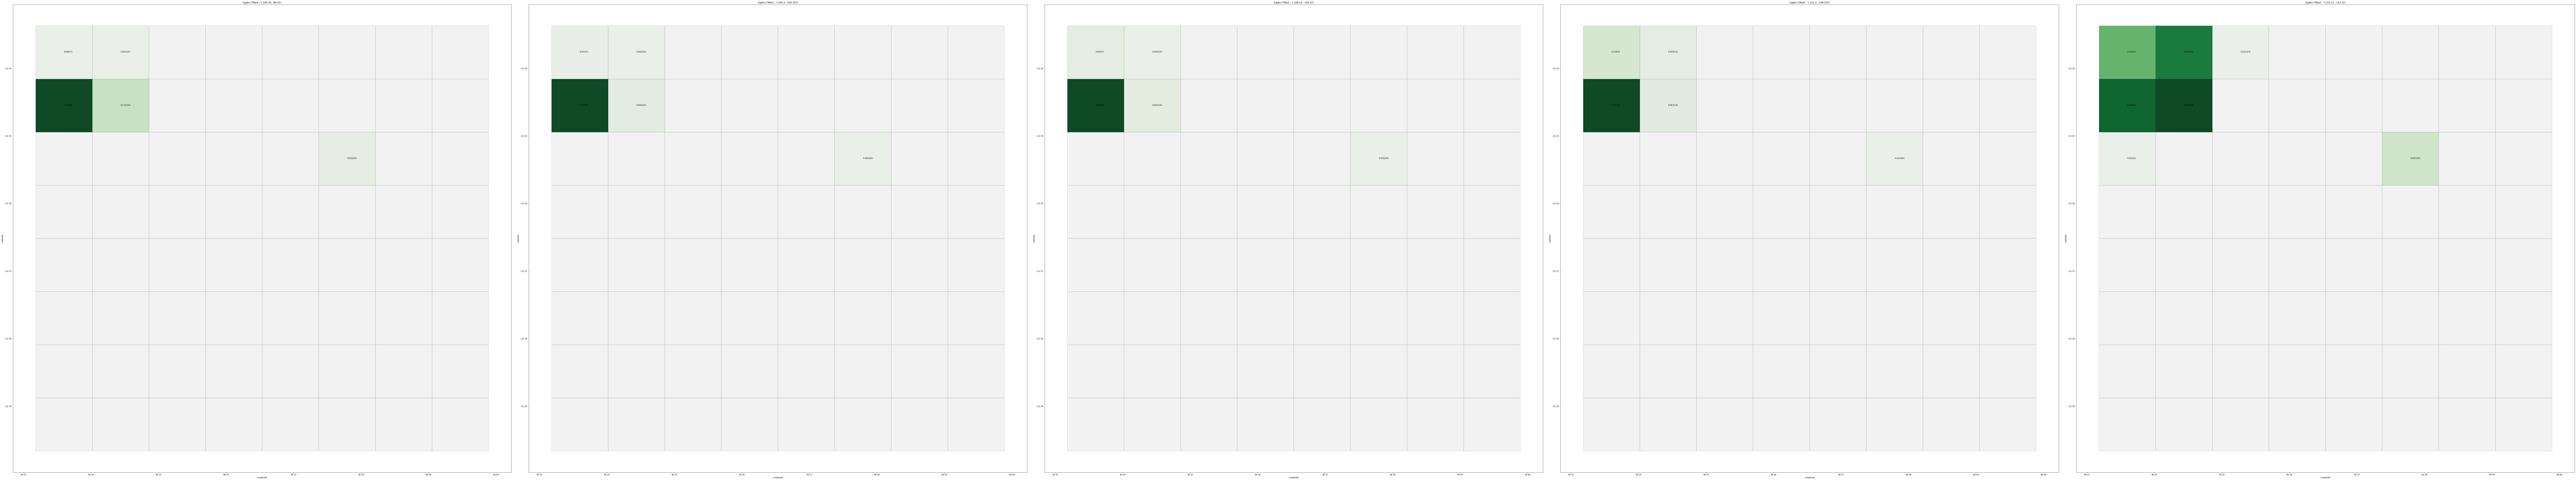

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(180,210), sharey=False)

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    grouped.get_group(key).plot("proba",cmap='Greens', ax=ax)
    grid.plot(ax=ax,facecolor='gray',alpha=.1,edgecolor='black',lw=2)
    ax.set(xlabel="Longitude", ylabel="Latitude")
    ax.set_title('tuple=%s'%str(key))
 

    res = t.loc[t['tuples_plot']==key]
    for idx, row in res.iterrows():
        ax.annotate(text=r"%.3f(%d)"%(row['proba'],row['id']), xy=row['coords'],xytext=row['coords'], xycoords='data',textcoords='data')

plt.tight_layout(pad=3.0)

In [54]:
def check_list(l):
    if not l:
        return ['None']
    else:
        return l

def create_tuples(row, column_name, method="None"):
    tuples = list()
    list_id = row['id'].unique()
    list_id = sorted(list_id)
    for idx in list_id :
        main = row[(row['gatewayname']=='Main') & (row['id']==idx)][column_name].tolist()
        lagon = row[(row['gatewayname']=='lagon') & (row['id']==idx)][column_name].tolist()
        dune = row[(row['gatewayname']=='dune') & (row['id']==idx)][column_name].tolist()
        mang = row[(row['gatewayname']=='mangrove') & (row['id']==idx)][column_name].tolist()
        

        if method=="None":
            for x,y,z,e in [(x,y,z,e) for x in check_list(main) for y in check_list(dune) for z in check_list(lagon) for e in check_list(mang)]:
                value = (x, y,z,e)
                tuples.append({ 'idcell':idx, 'val':value })
            
        elif method=="mean":
            value = ( np.nanmean(main), np.nanmean(lagon) , np.nanmean(dune), np.nanmean(mang) )
            tuples.append({ 'idcell':idx, 'val':value })
            
        elif method=="percentiles":
            value = ( np.nanpercentile(main,25), np.nanpercentile(main,75), 
                 np.nanpercentile(lagon,25), np.nanpercentile(lagon,75), 
                 np.nanpercentile(dune,25), np.nanpercentile(dune,75),
                np.nanpercentile(mang,25), np.nanpercentile(mang,75))
        
            tuples.append({ 'idcell':idx, 'val1':value[0], 'val2':value[1], 'val3':value[2], 
                           'val4':value[3], 'val5':value[4], 'val6':value[5], 'val7':value[6], 
                           'val8':value[7] })
        
    return pd.DataFrame(tuples)

#TODO : robustesse

In [55]:
df_tuples = create_tuples(df_proba_msg, 'group_rssi', method="None")
df_tuples.head()

idcell                                                val
0       4  (None, (-128.079, -124.05], (-124.05, -120.1],...
1       5              ((-116.15, -112.2], None, None, None)
2       5              ((-124.05, -120.1], None, None, None)
3       6  ((-100.35, -96.4], (-128.079, -124.05], None, ...
4       6  ((-104.3, -100.35], (-128.079, -124.05], None,...

In [56]:
rows, cols = (5, 5)
arr=[]
for i in range(rows):
    col = []
    for j in range(cols):
        col.append(0)
    arr.append(col)
print(arr)
print(len(arr))
print(arr[0])
x=[[1,2],[1,2,3],[1]]
a=np.array([np.array(xi) for xi in x])
print(a)
g=[1,2,3,4,6,7]
e=np.array_split(g, 3)
print(e)

[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
5
[0, 0, 0, 0, 0]
[array([1, 2]) array([1, 2, 3]) array([1])]
[array([1, 2]), array([3, 4]), array([6, 7])]


C:\Users\TIPAKA Lise-Marie\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


In [57]:
proba_tuples = (df_tuples.reset_index().groupby('val')['idcell'].value_counts()/ df_tuples.reset_index().groupby('val')['idcell'].count())
proba_tuples = pd.DataFrame(proba_tuples)
proba_tuples = proba_tuples.rename(columns = {'idcell': 'proba'}).reset_index()

In [58]:
occ_proba_tuples = pd.DataFrame(proba_tuples[proba_tuples['proba'] > 0.8].groupby('idcell')['proba'].count())
occ_proba_tuples = occ_proba_tuples.rename(columns = {'proba': 'count'}).reset_index()

In [59]:
t = pd.merge(grid, occ_proba_tuples, how='right', left_on='id', right_on='idcell')
t['coords'] = t['geometry'].apply(lambda x: x.representative_point().coords[:])
t['coords'] = [coords[0] for coords in t['coords']]

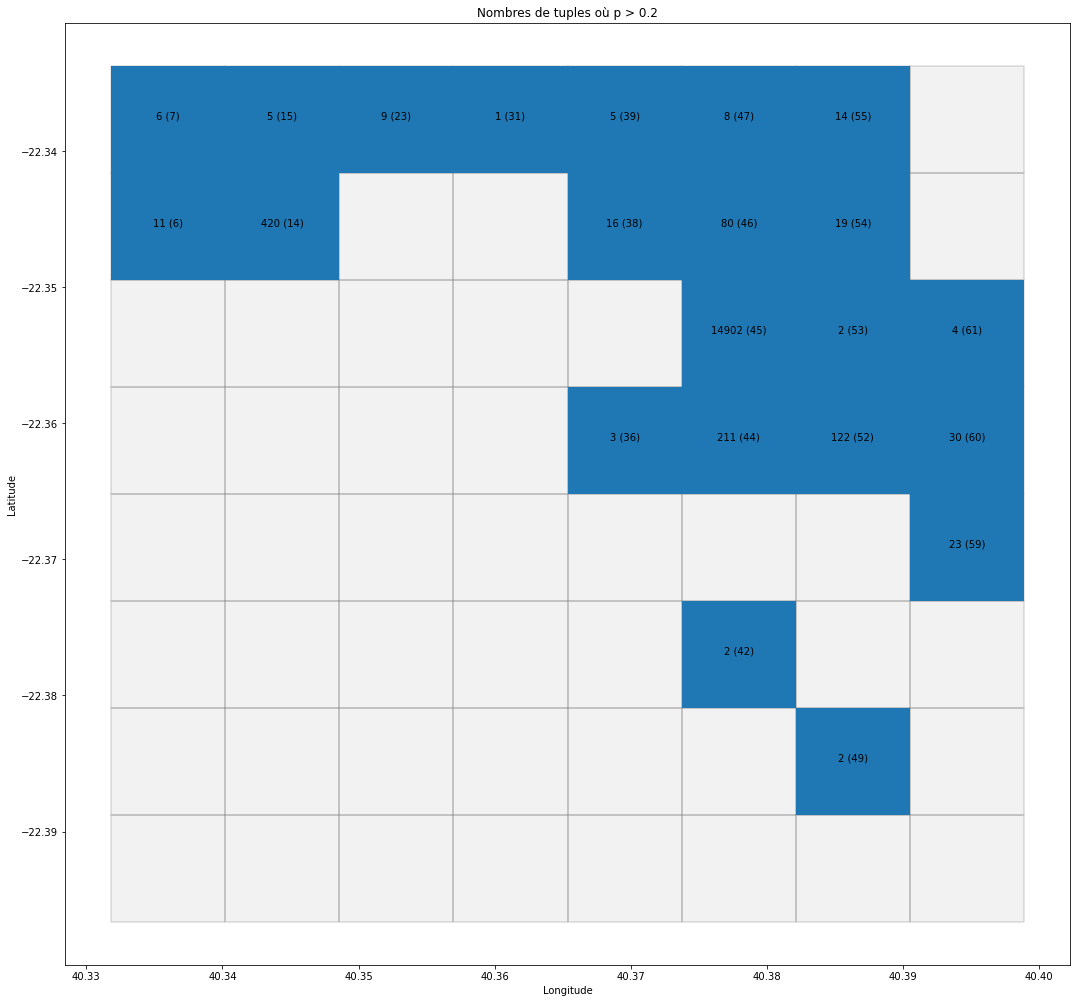

In [60]:
fig, ax = plt.subplots(figsize=(18,21))

grid.plot(ax=ax,facecolor='gray',alpha=.1,edgecolor='black',lw=2)
t.plot(ax=ax)
ax.set(xlabel="Longitude", ylabel="Latitude")
ax.set_title('Nombres de tuples où p > 0.2')
    
for idx, row in t.iterrows():
    ax.annotate(text=str(row['count'])+" ("+str(row['id'])+")", xy=row['coords'], horizontalalignment='center')
        
#plt.savefig('index.png', format='png')    

In [61]:
df_mean_tuples = create_tuples(pointInPolys, 'rssi', method="mean")
df_mean_tuples.head()

C:\Users\TIPAKA Lise-Marie\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


idcell                                     val
0       4           (nan, -121.0, -127.0, -128.0)
1       5                 (-118.5, nan, nan, nan)
2       6  (-94.27514231499052, nan, -128.0, nan)
3       7    (-109.52307692307693, nan, nan, nan)
4       8              (nan, -121.0, -119.0, nan)

In [62]:
df_perc_tuples = create_tuples(pointInPolys, 'rssi', method="percentiles")
df_perc_tuples = df_perc_tuples.rename(
    {'idcell': 'target','val1': 'MainPerc25', 'val2': 'MainPerc75', 
     'val3': 'LagonPerc25','val4': 'LagonPerc75', 'val5': 'DunePerc25',
     'val6': 'DunePerc75', 'val7': 'MangPerc25', 'val8': 'MangPerc75'
    }, axis=1)
df_perc_tuples.head()

C:\Users\TIPAKA Lise-Marie\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1366: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


target  MainPerc25  MainPerc75  LagonPerc25  LagonPerc75  DunePerc25  \
0       4         NaN         NaN       -121.0       -121.0      -127.0   
1       5     -120.25     -116.75          NaN          NaN         NaN   
2       6     -105.00      -83.00          NaN          NaN      -128.0   
3       7     -112.00     -105.00          NaN          NaN         NaN   
4       8         NaN         NaN       -121.0       -121.0      -119.0   

   DunePerc75  MangPerc25  MangPerc75  
0      -127.0      -128.0      -128.0  
1         NaN         NaN         NaN  
2      -128.0         NaN         NaN  
3         NaN         NaN         NaN  
4      -119.0         NaN         NaN

In [63]:
minDfTuplesValue = np.min(df_perc_tuples.min()) -2
df_perc_tuples = df_perc_tuples.where(pd.notnull(df_perc_tuples), minDfTuplesValue)
features = ['MainPerc25','MainPerc75','LagonPerc25','LagonPerc75','DunePerc25','DunePerc75','MangPerc25','MangPerc75']
x = df_perc_tuples.loc[:,features].values
y = df_perc_tuples.loc[:,['target']].values


x = StandardScaler().fit_transform(x)

In [64]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pca1', 'pca2'])
finalDf = pd.concat([principalDf, df_perc_tuples[['target']]],axis=1)

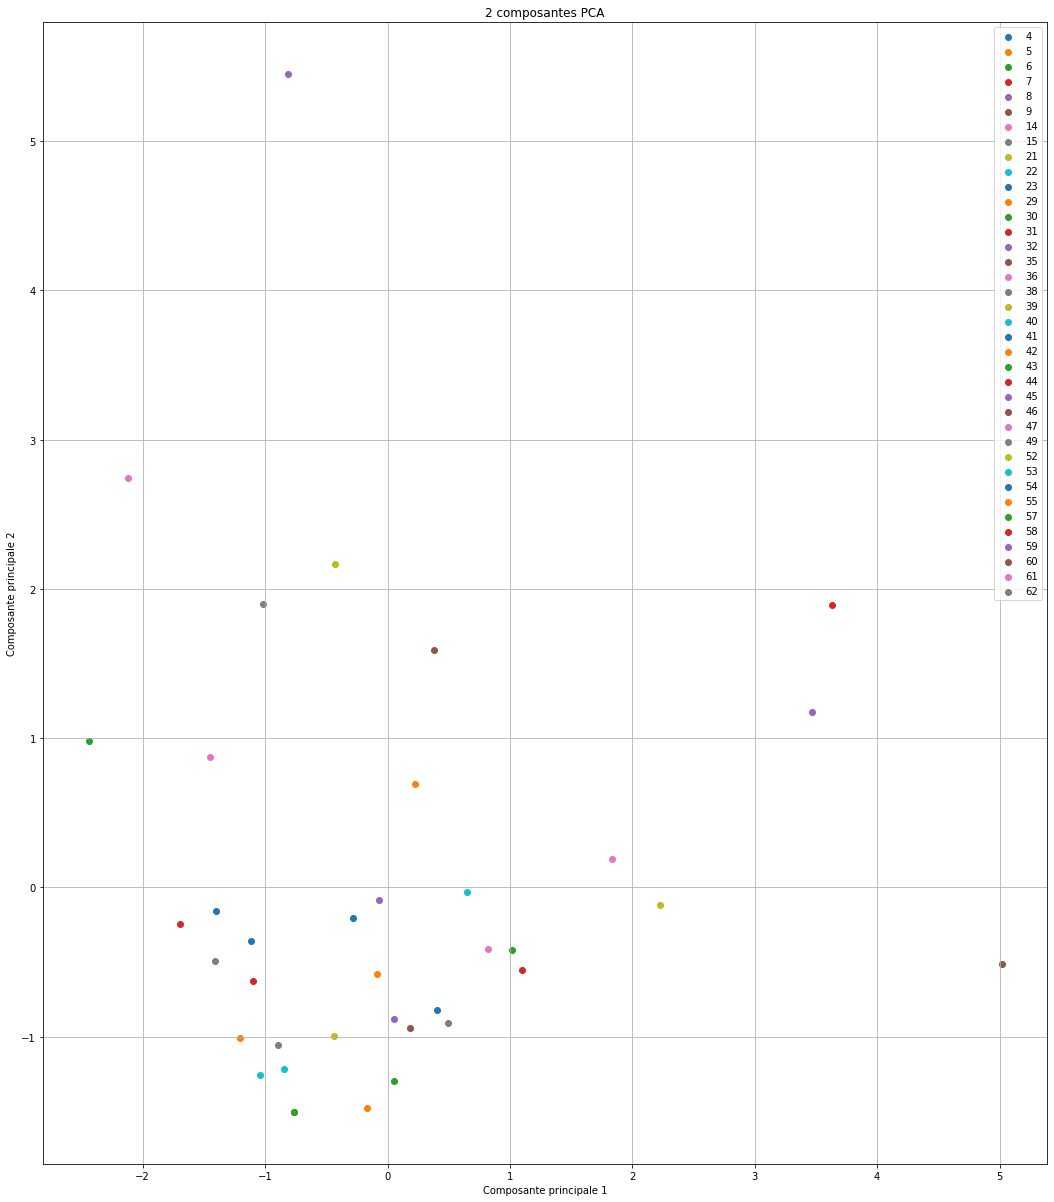

In [65]:
fig, ax = plt.subplots(figsize=(18,21))
ax.set_xlabel('Composante principale 1')
ax.set_ylabel('Composante principale 2')
ax.set_title('2 composantes PCA')

targets = df_perc_tuples['target'].unique()
targets = sorted(targets)

for target in targets:
    indicesToKeep = finalDf['target']==target
    ax.scatter(finalDf.loc[indicesToKeep, 'pca1'],
              finalDf.loc[indicesToKeep, 'pca2'])
    
ax.legend(targets)
ax.grid()

#### Area

In [66]:
gdfArea = gpd.GeoDataFrame(
    df_geo, crs = "EPSG:4326", geometry=gpd.points_from_xy(df_geo['objlng'], df_geo['objlat']))


In [67]:
gdfArea.head()

rssi     objlng     objlat gatewayname       group_rssi  \
0   -70  40.340537 -22.343824        Main  (-72.7, -68.75]   
1   -65  40.340147 -22.343997        Main  (-68.75, -64.8]   
2   -67  40.340096 -22.344038        Main  (-68.75, -64.8]   
3   -67  40.340106 -22.344044        Main  (-68.75, -64.8]   
4   -67  40.340106 -22.344044        Main  (-68.75, -64.8]   

                     geometry  
0  POINT (40.34054 -22.34382)  
1  POINT (40.34015 -22.34400)  
2  POINT (40.34010 -22.34404)  
3  POINT (40.34011 -22.34404)  
4  POINT (40.34011 -22.34404)

In [68]:
grouped = gdfArea.groupby('gatewayname')
gdfAreaPolys = gpd.GeoDataFrame()
geoms = []
geomsName = []
for key in grouped.groups.keys():
    minLon = min(grouped['objlng'].get_group(key))
    maxLon = max(grouped['objlng'].get_group(key))
    minLat = min(grouped['objlat'].get_group(key))
    maxLat = max(grouped['objlat'].get_group(key))
    
    tupleMinLattupleMinLon = Point(minLon, minLat)
    tupleMaxLattupleMaxLon = Point(maxLon, maxLat)
    tupleMaxLontupleMinLon = Point(minLon, maxLat)
    tupleMinLontupleMaxLon = Point(maxLon, minLat)
    points = [tupleMinLattupleMinLon, tupleMaxLontupleMinLon, tupleMaxLattupleMaxLon, tupleMinLontupleMaxLon,tupleMinLattupleMinLon]
    coords = [(p.x, p.y) for p in points]
    poly = LineString(coords)
    geoms.append(poly)
    geomsName.append(key)

gdfAreaPolys['geometry'] = geoms
gdfAreaPolys['gatewayname']= geomsName
gdfAreaPolys = gdfAreaPolys.set_crs('epsg:4326')

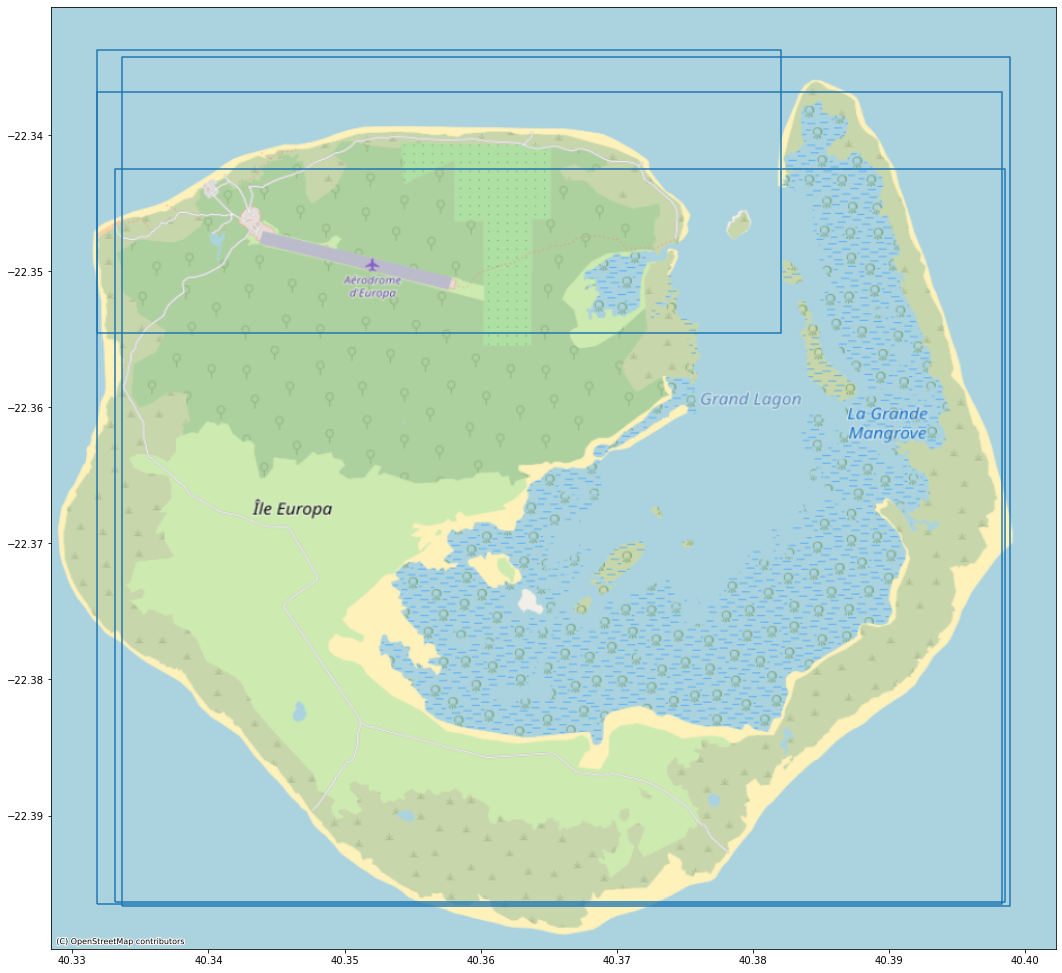

In [69]:
fig, ax = plt.subplots(figsize=(18,21))
gdfAreaPolys.plot(ax=ax)
ctx.add_basemap(ax, crs=gdfAreaPolys.crs, reset_extent=True,source=ctx.providers.OpenStreetMap.Mapnik)

In [70]:
gdfShp = gpd.read_file("./shapefile_map/OsmFile_multipolygons.shp")
gdfShp = gdfShp.set_crs("EPSG:4326") 

In [71]:
idx = [i for i in range(len(gdfShp))]
gdfShp['id']=idx

In [72]:
gdfShp['coords'] = gdfShp['geometry'].apply(lambda x: x.representative_point().coords[:])
gdfShp['coords'] = [coords[0] for coords in gdfShp['coords']]

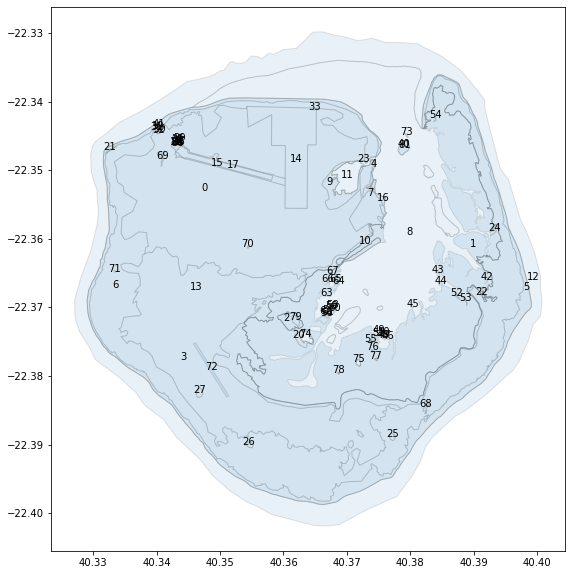

In [73]:
gdfShp.plot(figsize=(10, 10), alpha=0.1, edgecolor='k')
for idx, row in gdfShp.iterrows():
    plt.annotate(text=row['id'], xy=row['coords'],
                 horizontalalignment='center')

<AxesSubplot:>

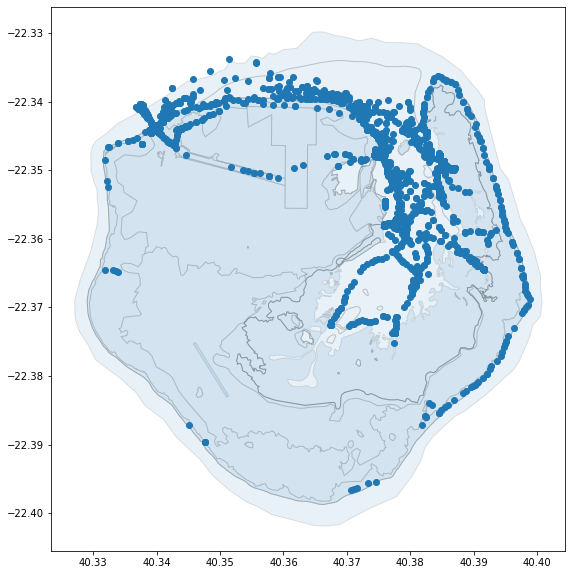

In [74]:
fig, ax = plt.subplots(figsize=(10, 10))
gdfShp.plot(alpha=0.1, edgecolor='k', ax=ax)
gdfArea.plot(ax=ax)

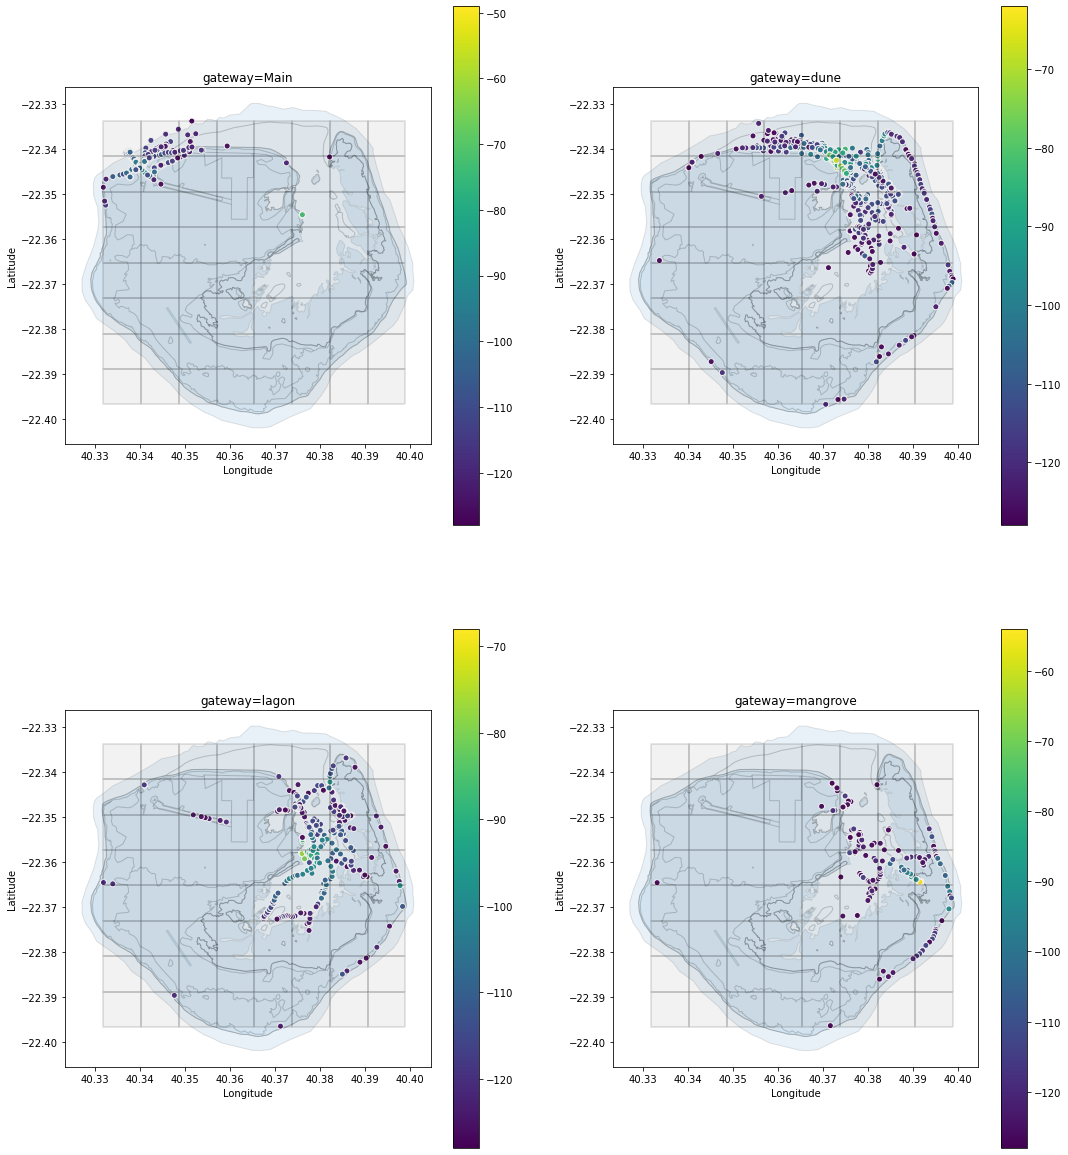

In [75]:
grouped = gdfArea.groupby('gatewayname')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,21),sharey=False)

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    gdfShp.plot(alpha=0.1, edgecolor='k', ax=ax)
    grouped.get_group(key).plot("rssi", cmap='viridis', ax=ax, edgecolors= "white",legend=True) 
    grid.plot(ax=ax,facecolor='gray',alpha=.1,edgecolor='black',lw=2)
    ax.set(xlabel="Longitude", ylabel="Latitude")
    ax.set_title('gateway=%s'%key)

In [76]:
pointInPolysArea = sjoin(gdf, gdfShp, how='left')
pointInPolysArea=gpd.GeoDataFrame(pointInPolysArea)
pointInPolysArea=pointInPolysArea.filter(['rssi','objlng','objlat','gatewayname','group_rssi','geometry','index_right'],axis=1)
pointInPolysArea = pointInPolysArea.rename(columns={'index_right': 'id'})

C:\Users\TIPAKA Lise-Marie\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  """Entry point for launching an IPython kernel.


In [77]:
pointInPolysArea.head()

rssi     objlng     objlat gatewayname       group_rssi  \
0   -70  40.340537 -22.343824        Main  (-72.7, -68.75]   
0   -70  40.340537 -22.343824        Main  (-72.7, -68.75]   
1   -65  40.340147 -22.343997        Main  (-68.75, -64.8]   
1   -65  40.340147 -22.343997        Main  (-68.75, -64.8]   
2   -67  40.340096 -22.344038        Main  (-68.75, -64.8]   

                     geometry    id  
0  POINT (40.34054 -22.34382)  13.0  
0  POINT (40.34054 -22.34382)   0.0  
1  POINT (40.34015 -22.34400)  13.0  
1  POINT (40.34015 -22.34400)  19.0  
2  POINT (40.34010 -22.34404)  13.0

In [78]:
len(pointInPolysArea)

15079

Text(0.5, 1.0, 'Clustering GPS Co-ordinates to Form Regions - Unweighted')

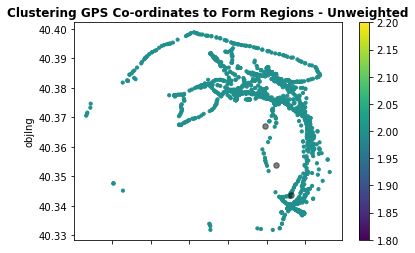

In [79]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
features = ['objlat','objlng','rssi']
X = pd.DataFrame(pointInPolys.loc[:,features])
kmeans.fit(X) # Compute k-means clustering.


X['cluster_label'] = kmeans.fit_predict(X)

centers = kmeans.cluster_centers_ # Coordinates of cluster centers.

labels = kmeans.predict(X[X.columns[1:4]])

#Visualise Resutls
X.plot.scatter(x = 'objlat', y = 'objlng', c=labels, s=10, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=30, alpha=0.5)
plt.title('Clustering GPS Co-ordinates to Form Regions - Unweighted',fontsize=12, fontweight='bold')

In [80]:
k=5
features = ['objlat','objlng']
X = pointInPolys.loc[:,features].values #groupby

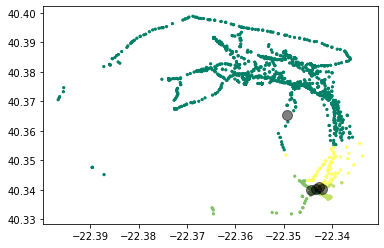

In [81]:
from sklearn.cluster import KMeans 
kmeans = KMeans(n_clusters=k, init='random', n_init=1, random_state=0, max_iter=1) 
kmeans.fit(X) 
y_kmeans = kmeans.predict(X) # cluster index for each observation 
centers = kmeans.cluster_centers_ # cluster center coordinates 
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=5, cmap='summer') 
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5) 

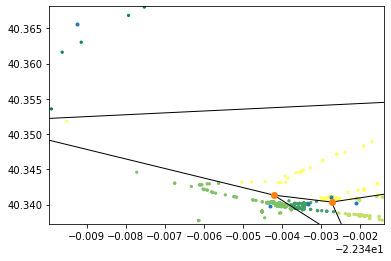

In [82]:
from scipy.spatial import Voronoi, voronoi_plot_2d 
vor = Voronoi(centers) 
voronoi_plot_2d(vor) 
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=5, cmap='summer') 
plt.show() 

Figure(432x288)


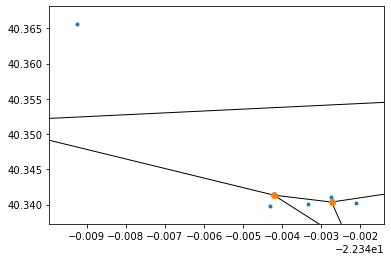

In [83]:
print(voronoi_plot_2d(vor))

center =  (40.36364018851433, -22.358213644634176)
angle of rotation =  0.011241259636625959
axes =  (0.025789912258539216, 0.014050534111929061)


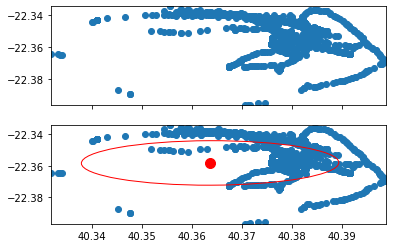

In [84]:
import numpy as np
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

pointsGtw=df.loc[df['gatewayname']!="Main"]
arr=[]
for x,y in zip(pointsGtw['objlng'],pointsGtw['objlat']):
    arr.append([x,y])

points= np.reshape(arr,(-1,2))

x = np.array(pointsGtw['objlng'])
y = np.array(pointsGtw['objlat'])

ell = EllipseModel()
ell.estimate(points)

xc, yc, a, b, theta = ell.params

print("center = ",  (xc, yc))
print("angle of rotation = ",  theta)
print("axes = ", (a,b))

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
axs[0].scatter(x,y)

axs[1].scatter(x, y)
axs[1].scatter(xc, yc, color='red', s=100)
axs[1].set_xlim(x.min(), x.max())
axs[1].set_ylim(y.min(), y.max())

ell_patch = Ellipse((xc, yc), 2*a, 2*b, theta*180/np.pi, edgecolor='red', facecolor='none')

axs[1].add_patch(ell_patch)
plt.show()

In [85]:
vertices= ell_patch.get_verts()
polyEllipse=Polygon(vertices)